In [1]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "Amin Fathi" #@param {type:"string"}
StudentNumber =  400722102#@param {type:"integer"}

#Imports

برای پیاده سازی این سوال از لینک زیر استفاده شده است :
https://github.com/prashil2792/Question-Answering-System-Deep-Learning/blob/master/Question%20Answering%20Memory%20Network.ipynb

In [2]:
%%capture
!pip install transformers

In [3]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re
import pandas as pd

from transformers import TFBertModel, BertTokenizer
%matplotlib inline

In [ ]:
!nvidia-smi # check if gpu mode is selected

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

# 1. LSTM- Q&A

This is a bonus section with extra score for those who coplete this section.

## 1.2 Preprocessing

Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

In [ ]:
%%capture
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xvzf babi_tasks_1-20_v1-2.tar.gz

In [ ]:
challenges = [
    'qa1_single-supporting-fact',
    'qa2_two-supporting-facts',
]
train_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_train.txt'
test_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_test.txt'

In [ ]:
def word_tokenizer(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [ ]:
def parse_stories(lines, only_supporting=False, tokenize = True):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            if tokenize:
                q = word_tokenizer(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            if tokenize:
                sent = word_tokenizer(line)
            else:
                sent = line
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [ ]:
def get_stories(f, only_supporting=False, max_length=None, tokenize=True):
    data = parse_stories(f.readlines(), only_supporting=only_supporting, tokenize=tokenize)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(story[0]+story[1], q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [ ]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  
    ########################################
    #     Put your implementation here     #
    ########################################
    storyT = list()
    queryT = list()
    answerT = list()

    for story, query, answer in data:
        # creating list of story word indices
        story1 = [word_idx[w] for w in story]
        # creating list of query word indices
        query1 = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        answer1 = np.zeros(len(word_idx) + 1)
        # creating label 1 for the answer word index
        answer1[word_idx[answer]] = 1
        storyT.append(story1)
        queryT.append(query1)
        answerT.append(answer1)

    return (pad_sequences(storyT, maxlen=story_maxlen),
            pad_sequences(queryT, maxlen=query_maxlen),
            np.array(answerT))


    #return inputs_train, queries_train, answers_train



Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [ ]:
train_stories = get_stories(open(train_file_path), tokenize=True)
test_stories = get_stories(open(test_file_path), tokenize=True)

In [ ]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [ ]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [ ]:
story_maxlen, query_maxlen

(14, 4)

In [ ]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 14 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [ ]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 14), (10000, 4), (10000, 22))

In [ ]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 14)
inputs_test shape: (1000, 14)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [ ]:
def plot_acc(history, title):
  
  # This function should show not only the plot of accuracy on training and validation set
  # but also it should show the maximum value of accuracy with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.plot(history.history['accuracy'],label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show() 

In [ ]:
def plot_loss(history, title):
  
  # This function should show not only the plot of loss on training and validation set
  # but also it should show the minimum value of loss with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show() 

Define model's hyperparameters

In [ ]:
train_epochs = 20
batch_size = 32
lstm_size = 64

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [ ]:
# define the model: 

input_sequence = tf.keras.layers.Input((story_maxlen,))
question = tf.keras.layers.Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

########################################
#     Put your implementation here     #
########################################
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)


Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
# build the final model
model = tf.keras.models.Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

The model architecture should look like this:

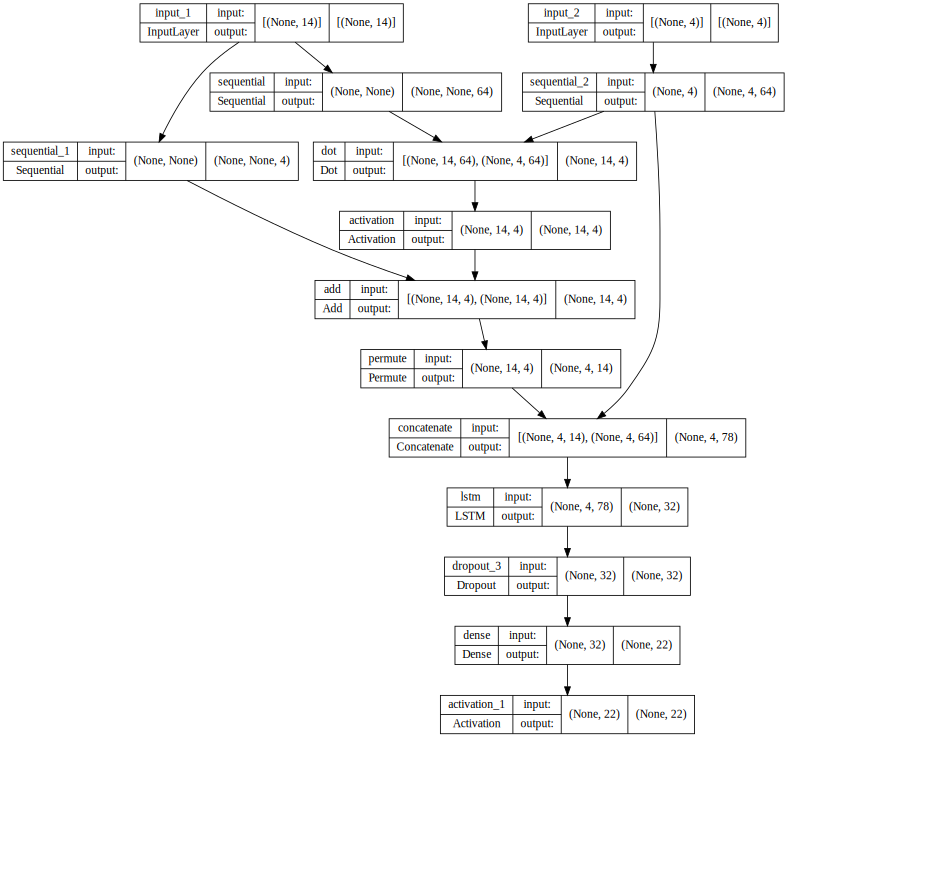

In [ ]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     1408        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 64)        1408        ['input_2[0][0]']                
                                                                                              

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

Epoch 1/20
  3/313 [..............................] - ETA: 12s - loss: 1.7391 - accuracy: 0.2708

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 13s 41ms/step - loss: 1.7624 - accuracy: 0.2407 - val_loss: 1.7490 - val_accuracy: 0.2830
Epoch 2/20
313/313 [==============================] - 13s 43ms/step - loss: 1.7622 - accuracy: 0.2441 - val_loss: 1.7514 - val_accuracy: 0.2820
Epoch 3/20
313/313 [==============================] - 13s 40ms/step - loss: 1.7605 - accuracy: 0.2520 - val_loss: 1.7465 - val_accuracy: 0.2820
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 1.7577 - accuracy: 0.2532 - val_loss: 1.7465 - val_accuracy: 0.2850
Epoch 5/20
313/313 [==============================] - 13s 41ms/step - loss: 1.7588 - accuracy: 0.2546 - val_loss: 1.7388 - val_accuracy: 0.2900
Epoch 6/20
313/313 [==============================] - 13s 40ms/step - loss: 1.7567 - accuracy: 0.2611 - val_loss: 1.7372 - val_accuracy: 0.2990
Epoch 7/20
313/313 [==============================] - 12s 40ms/step - loss: 1.7554 - accuracy: 0.2622 - val_loss: 1.7351 - val_accuracy: 0.2980
Epo

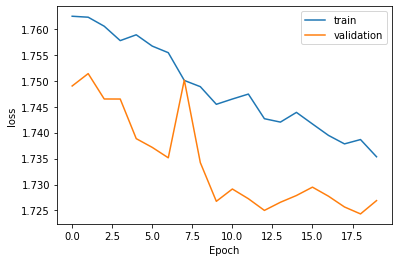

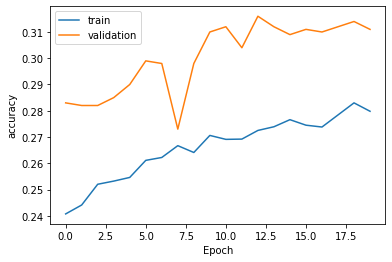

In [ ]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history,"Loss")
plot_acc(history,"Accuracy")

model.save('model.h5')

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [ ]:
for i in range(0,10):
    current_inp = test_stories[2*i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("-----------------------------------------------------------------------------------------")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bathroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth: garden
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Trut

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [ ]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp = input().split(' ')
    print('Please input a query')
    user_query_inp = input().split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

-------------------------------------------------------------------------------------------
Custom User Queries (Make sure there are spaces before each word)
-------------------------------------------------------------------------------------------
Please input a story
Mary went to the bathroom . John moved to the hallway . Mary travelled to the office .
Please input a query
Where is Mary ?


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Result
Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . Where is Mary ? | Prediction: office
-------------------------------------------------------------------------------------------
Please input a story


KeyboardInterrupt: ignored

In [ ]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

$\color{red}{\text{Write your answer in document}}$



**Answer : **
مشخصا مدل آموزش داده شده توانایی هندل کردن دنباله های طولانی را ندارد ، استفاده از lstm ها می تواند کمک کننده باشد.


#  2. Hands on Transformers

## 2.1 Preprocessing

We will use dataset from tfds api in this sections. These datasets are prepared in [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) format which can be used in a pipeline to read data and do the needed preprocessings on that. But for our purpos we can't use pipeline functions to achieve our goal so we will exctract dataset from Dataset format and later we will convert it back.

In [4]:
import tensorflow_datasets as tfds
(train_data, validation_data), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)
print('info', ds_info)

info tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


## 2.2 Tokenization
There are 3 important parts to prepare the transformer model for training and inference: Tokenizer, Confing and the Model itself.

Tokenizer as it's clear from its name is a tool to convert input string to tokens and assign an id to each one so it can be passed to model input. Tokenizer is trained prior to training the main model using [sentence piece](https://github.com/google/sentencepiece) library.

There are two important things to consider with tokenization:
1. As part of transformer models there are special tokens that should be added to input string before passing it to model. These tokens are in the tokenizer class.
2. Alongside the the ids of input string there are two other inputs witch each sample: Attention Mask, Token Type IDs. Feel free to google these terms to find out more.


In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [6]:
max_length_test = 20
test_sentence = "This film is awsome you should watch it"

# add special tokens
test_sentence_with_special_tokens = '[CLS]' + test_sentence + '[SEP]'
tokenized = tokenizer.tokenize(test_sentence_with_special_tokens)
print('tokenized', tokenized)


# convert tokens to ids
input_ids = tokenizer.convert_tokens_to_ids(tokenized)

# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)
# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)
# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test

bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
} 
print(bert_input)

tokenized ['[CLS]', 'this', 'film', 'is', 'aw', '##some', 'you', 'should', 'watch', 'it', '[SEP]']
{'token_ids': [101, 2023, 2143, 2003, 22091, 14045, 2017, 2323, 3422, 2009, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


We can do all the above operations to prepare each input or we can use encode_plus function which does the boilerpolate code. Use encode_plus to get output like above for test sentence.

In [7]:
bert_input = tokenizer.encode_plus( # same as calling tokenizer itself e.g tokenizer(....)
                        test_sentence,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_test, # max length of the text that can go to BERT
                        padding='max_length', # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
print(bert_input)

{'input_ids': [101, 2023, 2143, 2003, 22091, 14045, 2017, 2323, 3422, 2009, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


We should convert each sample to above format. To do this we will iterate overt dataset and convert each sample. We will put converted samples in tf.data.Dataset format. We will also apply a [map function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) on dataset to convert it to dictionary format. We don't need token type ids as we have one token type in this task. Complete the functions below.

In [8]:
import numpy as np

def map_example_to_dict(input_ids, attention_mask, label):
    return {
        "input_ids": input_ids,
        #"token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }, label


def encode_examples(ds, max_sequence_length):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    attention_mask_list = []
    labels = []
   # token_type_ids_list = []

    if (max_sequence_length > 0):
      ds = ds.take(max_sequence_length)

    for review, label in tfds.as_numpy(ds):
      bert_input= tokenizer.encode_plus(review.decode(), 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_sequence_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
      #bert_input = convert_example_to_feature(review.decode())
      input_ids_list.append(bert_input['input_ids'])
      #token_type_ids_list.append(bert_input['token_type_ids'])
      attention_mask_list.append(bert_input['attention_mask'])
      labels.append([label])


    #iterate over ds and extract input ids and attention masks for each sample

    # reshape each input_ids_list and attention_mask_list to (-1, max_sequence_length)
    # reshape labels to (-1, 1)

    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, labels)).map(map_example_to_dict)

In [9]:
# train dataset
batch_size = 8
max_sequence_length = 256 # can be up to 512 for BERT but I have resourse Eroor in colab

train_data_encoded = encode_examples(train_data, max_sequence_length).batch(batch_size)
validation_data_encoded = encode_examples(validation_data.take(5000), max_sequence_length).batch(batch_size)

print(train_data_encoded)
print(validation_data_encoded)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWa

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>
<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>


## 2.3 Defining model

In [10]:
from transformers import TFBertForSequenceClassification

########################################
#     Put your implementation here    #
########################################

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
print(model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
None


## 2.4 Training

In [12]:
epochs = 5
########################################
#     Put your implementation here     # best accuracy: 96.88 % in epoch=5
########################################
model.compile(optimizer= tf.keras.optimizers.Adam(2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data_encoded, validation_data=validation_data_encoded, epochs=epochs)

Epoch 1/5
32/32 [==============================] - 23s 700ms/step - loss: 0.6846 - accuracy: 0.5664 - val_loss: 0.6282 - val_accuracy: 0.6992
Epoch 2/5
32/32 [==============================] - 23s 711ms/step - loss: 0.4451 - accuracy: 0.8438 - val_loss: 0.4396 - val_accuracy: 0.8008
Epoch 3/5
32/32 [==============================] - 23s 716ms/step - loss: 0.2501 - accuracy: 0.9141 - val_loss: 0.6360 - val_accuracy: 0.7422
Epoch 4/5
32/32 [==============================] - 22s 706ms/step - loss: 0.1896 - accuracy: 0.9336 - val_loss: 0.5446 - val_accuracy: 0.7773
Epoch 5/5
32/32 [==============================] - 23s 717ms/step - loss: 0.1251 - accuracy: 0.9648 - val_loss: 0.4108 - val_accuracy: 0.8320


## 2.5 Testing
Feel free to change these senetences and test the model.

In [13]:
pred_sentences = ["This is an awful film do not watch it.", "This is an aswsome film you should watch it."]

In [14]:


# testing pred_sentences[i]
tf_batch = tokenizer(pred_sentences, max_length=128, add_special_tokens = True, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']

########################################
#     Put your implementation here    #
########################################
label = tf.argmax(tf_predictions, axis=1).numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

This is an awful film do not watch it. :  Negative
This is an aswsome film you should watch it. :  Negative


This is an awful film do not watch it. : 

 Negative
 
This is an aswsome film you should watch it. : 

 Positive

$\color{red}{\text{Write your answer in document}}$

1. When token type ids is useful?
2. What is the main idea of transformer models? Explain it.
3. What can be challenges to transformers if input sequences are very long? Why?

# GPT: for further study (It has no grade)

The task is to train poem based on GPT-2 model which is available in transformers library. You will choose poets of Shakespeare and train GPT-2 on that dataset and produce some sample poets.

Solution link: http://education.abcom.com/using-gpt-2-to-write-like-shakespeare/



In [15]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

TensorFlow is already loaded. Please restart the runtime to change versions.


In [16]:
!nvidia-smi

Thu Jun  9 07:36:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   8624MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2022-06-09 07:36:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.005s  

2022-06-09 07:36:10 (207 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [18]:
# Downloading GPT-2

########################################
#   Put your implementation here    #
########################################

In [19]:
# Finetune GPT-2

########################################
#   Put your implementation here     #
########################################

In [20]:
# Generate Text From The Trained Model

########################################
#   Put your implementation here     #
########################################